In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import rc
import platform

# 시스템에 따라 한글 폰트 설정
if platform.system() == "Darwin":  # macOS
    rc('font', family='AppleGothic')
elif platform.system() == "Windows":  # Windows
    rc('font', family='Malgun Gothic')
else:  # Linux (예: Ubuntu)
    rc('font', family='NanumGothic')


# 음수 값이 깨지는 현상 방지
plt.rcParams['axes.unicode_minus'] = False

In [43]:
# 국채 수익률
rf = pd.read_csv ('../API/rf.csv')
rf = rf['CLSPRC_YD'].mean()*0.01

krx_data = pd.read_csv('../API/krx_data.csv')
kospi_data = pd.read_csv('../API/kospi_1year_data.csv')

beta_df = pd.read_csv('top_200_betas.csv')

#kospi_data 중 사용하게 될 kospi200 지수를 사용
kospi_200 = kospi_data[kospi_data['IDX_NM'] == '코스피 200'][['BAS_DD', 'FLUC_RT']]
kospi_200['Market_Return'] = pd.to_numeric(kospi_200['FLUC_RT'], errors='coerce') / 100  # 퍼센트에서 소수로 변환

In [35]:
# 연간 수익률 계산 코드
# 마지막 날짜 확인
latest_date = krx_data['BAS_DD'].max()

# 연간 데이터 필터링 (마지막 날짜 기준 같은 연도 데이터)
latest_year = str(latest_date)[:4]  # 연도만 추출
yearly_data = krx_data[krx_data['BAS_DD'].astype(str).str.startswith(latest_year)]

# FLUC_RT를 숫자로 변환
yearly_data['FLUC_RT'] = pd.to_numeric(yearly_data['FLUC_RT'], errors='coerce')

# 종목별 연간 주가 변동폭 계산
yearly_fluc_rt = yearly_data.groupby('ISU_NM')['FLUC_RT'].sum().reset_index()
yearly_fluc_rt.rename(columns={'FLUC_RT': 'Yearly_FLUC_RT'}, inplace=True)

yearly_fluc_rt

/var/folders/_t/w69h1jqn26q43r4mwvlg_c1m0000gn/T/ipykernel_70757/4266616683.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yearly_data['FLUC_RT'] = pd.to_numeric(yearly_data['FLUC_RT'], errors='coerce')


,ISU_NM,Yearly_FLUC_RT
0,AJ네트웍스,0.23
1,AK홀딩스,-27.78
2,BGF,-3.78
3,BGF리테일,-10.77
4,BNK금융지주,33.33
...,...,...
980,휴비스,-36.18
981,휴스틸,-15.28
982,흥국화재,25.52
983,흥국화재우,18.99


In [45]:
# 시총기준 상위 200개 기업 정렬

# MKTCAP 칼럼을 숫자로 변환
krx_data['MKTCAP'] = pd.to_numeric(krx_data['MKTCAP'], errors='coerce')

# 변환 후 결측값이 있는지 확인
print(krx_data['MKTCAP'].isnull().sum())

# 가장 최근 날짜 찾기
latest_date = krx_data['BAS_DD'].max()

# 최신 날짜 데이터 필터링
latest_data = krx_data[krx_data['BAS_DD'] == latest_date]

# MKTCAP 기준 상위 200개 기업 정렬
top_200_companies = latest_data.sort_values(by='MKTCAP', ascending=False).head(200)

# 필요한 칼럼 정리 (ISU_NM, MKTCAP)
result = top_200_companies[['BAS_DD', 'ISU_NM', 'TDD_CLSPRC']]

# 결과 확인
result

0


,BAS_DD,ISU_NM,TDD_CLSPRC
232312,20241022,삼성전자,57700
232033,20241022,SK하이닉스,187800
231963,20241022,LG에너지솔루션,381500
232307,20241022,삼성바이오로직스,1059000
232781,20241022,현대차,234500
...,...,...,...
232239,20241022,롯데칠성,118000
232171,20241022,더블유게임즈,50800
232773,20241022,현대백화점,46050
232229,20241022,롯데렌탈,29400


In [49]:
# 상위 200개 기업에 연간 수익률 붙이기.

# result에 포함된 종목만 필터링
filtered_fluc_rt = yearly_fluc_rt[yearly_fluc_rt['ISU_NM'].isin(result['ISU_NM'])]

# result 데이터프레임과 연간 변동폭 데이터 병합
result_with_fluc = result.merge(filtered_fluc_rt, on='ISU_NM', how='left')

result_with_fluc

,BAS_DD,ISU_NM,TDD_CLSPRC,Yearly_FLUC_RT
0,20241022,삼성전자,57700,-27.20
1,20241022,SK하이닉스,187800,38.27
2,20241022,LG에너지솔루션,381500,-6.04
3,20241022,삼성바이오로직스,1059000,36.73
4,20241022,현대차,234500,20.40
...,...,...,...,...
195,20241022,롯데칠성,118000,-19.30
196,20241022,더블유게임즈,50800,27.50
197,20241022,현대백화점,46050,-8.55
198,20241022,롯데렌탈,29400,7.47


In [53]:
# beta_df와 result_with_fluc 데이터프레임 병합
final_result = result_with_fluc.merge(beta_df, on='ISU_NM', how='left')
final_result.rename(columns={'Yearly_FLUC_RT': 'Stock_Returns', 'Beta': '베타 값'}, inplace=True)

# 결과 확인
print(final_result.head())

# 필요하면 CSV로 저장
final_result.to_csv("final_result_with_beta.csv", index=False, encoding="utf-8-sig")


     BAS_DD    ISU_NM  TDD_CLSPRC  Stock_Returns      베타 값
0  20241022      삼성전자       57700         -27.20  1.117357
1  20241022    SK하이닉스      187800          38.27  1.647635
2  20241022  LG에너지솔루션      381500          -6.04  0.922005
3  20241022  삼성바이오로직스     1059000          36.73  0.472365
4  20241022       현대차      234500          20.40  1.025313


In [55]:
Market_Return = pd.to_numeric(kospi_200['FLUC_RT'], errors='coerce') / 100  # 퍼센트에서 소수로 변환

In [68]:
Market_Return = Market_Return.mean()

In [70]:
def plot_sml(stock_name, data, risk_free_rate=rf, market_return=Market_Return):
    """
    SML(Security Market Line)을 그리는 함수.
    
    Args:
        stock_name (str): 종목명 (ISU_NM).
        data (pd.DataFrame): 종목명과 베타 값이 포함된 데이터프레임.
        risk_free_rate (float): 무위험 수익률 (기본값: 국채 수익률 3년물).
        market_return (float): 시장의 기대 수익률 (기본값: 코스피 연간 수익률).
    """
    # 종목 데이터 필터링
    if stock_name not in data['ISU_NM'].values:
        print(f"종목명 {stock_name}이 데이터에 없습니다.")
        return

    stock_beta = data[data['ISU_NM'] == stock_name]['베타 값'].values[0]

    # SML 라인 정의
    beta_range = np.linspace(0, 2, 100)  # 베타 값 범위
    sml_returns = risk_free_rate + beta_range * (market_return - risk_free_rate)

    # 해당 종목의 예상 수익률
    stock_expected_return = risk_free_rate + stock_beta * (market_return - risk_free_rate)

    # 그래프 그리기
    plt.figure(figsize=(10, 6))
    plt.plot(beta_range, sml_returns, label="SML (Security Market Line)", color='blue')
    plt.scatter(stock_beta, stock_expected_return, color='red', label=f"{stock_name} (Beta={stock_beta:.2f})")
    
    # 축, 제목 및 기타 설정
    plt.title(f"SML and Expected Return for {stock_name}", fontsize=14)
    plt.xlabel("Beta (β)", fontsize=12)
    plt.ylabel("Expected Return (%)", fontsize=12)
    plt.axhline(y=risk_free_rate, color='gray', linestyle='--', label=f"Risk-Free Rate ({risk_free_rate * 100:.2f}%)")
    plt.legend()
    plt.grid()
    plt.show()

In [78]:

def predict_stock_price(stock_name, data, current_price_col='ClosePrice', beta_col='베타 값',
                        risk_free_rate=rf, market_return=Market_Return, trading_days=20):
    """
    1개월 후 주식 가격을 SML 기반으로 예측하는 함수.

    Args:
        stock_name (str): 종목명 (ISU_NM).
        data (pd.DataFrame): 종목명, 베타 값 및 현재 가격 등이 포함된 데이터프레임.
        current_price_col (str): 현재 주가 열 이름 (기본값: 'ClosePrice').
        beta_col (str): 베타 값 열 이름 (기본값: '베타 값').
        risk_free_rate (float): 무위험 수익률 (기본값: 3%).
        market_return (float): 시장의 기대 수익률 (기본값: 8%).
        trading_days (int): 예측 기간의 영업일 수 (기본값: 20, 약 1개월).

    Returns:
        float: 1개월 후 예상 주식 가격.
    """
    # Check if the stock exists in the data
    if stock_name not in data['ISU_NM'].values:
        return {"error": f"종목명 '{stock_name}'이 데이터에 없습니다."}

    # Get the stock data
    stock_data = data[data['ISU_NM'] == stock_name].iloc[0]
    current_price = stock_data['TDD_CLSPRC']  # 현재 가격은 'TDD_CLSPRC' 열에서 가져옴
    beta_value = stock_data[beta_col]

    # Calculate expected return using SML
    expected_return = risk_free_rate + beta_value * (market_return - risk_free_rate)

    # Calculate about 1 month (20 trading days) growth factor
    growth_factor = (1 + expected_return) ** (trading_days / 252)  # 252 영업일 기준 연율화

    # Predict future stock price
    predicted_price = current_price * growth_factor

    return {
        "종목명": stock_name,
        "현재 주가": current_price,
        "기대 수익률": expected_return,
        "1개월 후 예상 주가": predicted_price
    }

In [85]:
def plot_dynamic_stock_price_projection_emphasized(stock_name, data, risk_free_rate, market_return, current_price_col='ClosePrice', beta_col='베타 값'):
    """
    베타 값을 기반으로 시간이 지남에 따라 변화하는 예상 주가를 시계열 그래프로 표시.
    작은 변화량을 강조하기 위해 Y축 범위를 조정.

    Args:
        stock_name (str): 종목명.
        data (pd.DataFrame): 종목명, 베타 값 및 현재 가격 등이 포함된 데이터프레임.
        risk_free_rate (float): 무위험 수익률.
        market_return (float): 시장의 기대 수익률.
        current_price_col (str): 현재 주가 열 이름.
        beta_col (str): 베타 값 열 이름.
    """
    # Check if the stock exists in the data
    if stock_name not in data['ISU_NM'].values:
        print(f"종목명 '{stock_name}'이 데이터에 없습니다.")
        return

    # Get stock data
    stock_data = data[data['ISU_NM'] == stock_name].iloc[0]
    current_price = stock_data['TDD_CLSPRC']  # 현재 가격은 'TDD_CLSPRC' 열에서 가져옴
    beta_value = stock_data[beta_col]

    # Calculate daily returns using SML
    expected_return = risk_free_rate + beta_value * (market_return - risk_free_rate)
    daily_return = (1 + expected_return) ** (1 / 252) - 1  # 일별 수익률 (252 영업일 기준)

    # Simulate price changes over 20 trading days
    trading_days = np.arange(1, 21)  # 20 trading days
    projected_prices = [current_price]  # 시작 가격
    for _ in trading_days[1:]:
        next_price = projected_prices[-1] * (1 + daily_return)
        projected_prices.append(next_price)

    # Adjust Y-axis range to emphasize small changes
    min_price = min(projected_prices) * 0.999
    max_price = max(projected_prices) * 1.001

    # Plot the data
    plt.figure(figsize=(10, 6))
    plt.plot(trading_days, projected_prices, label=f"{stock_name} 예상 주가", marker='o', color='blue')
    plt.axhline(y=current_price, color='gray', linestyle='--', label=f"현재 주가: {current_price:,}원")
    plt.title(f"{stock_name} 1개월 예상 주가 변화 (베타 기반)", fontsize=14)
    plt.xlabel("거래일", fontsize=12)
    plt.ylabel(f"주가 (원)", fontsize=12)
    plt.ylim(min_price, max_price)  # Y축 범위 조정
    plt.legend()
    plt.grid()
    plt.show()

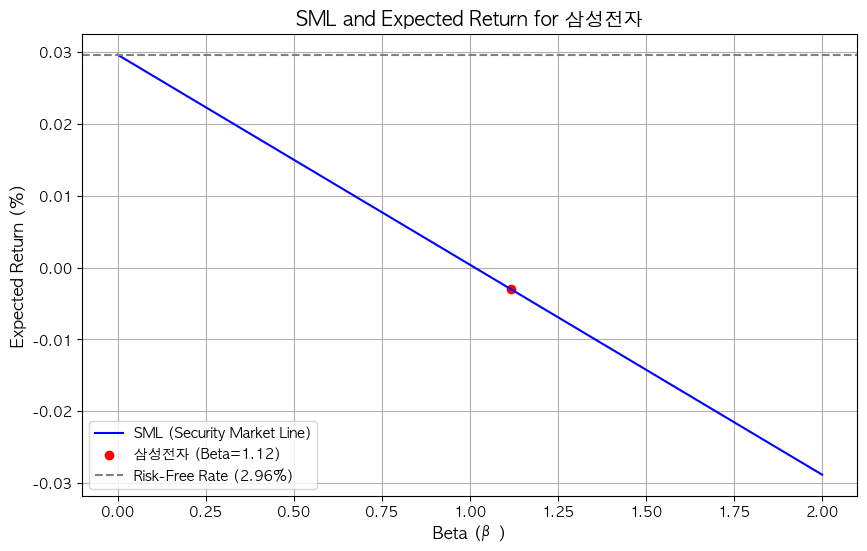

In [81]:
plot_sml('삼성전자', final_result)

In [83]:
prediction = predict_stock_price(stock_name='삼성전자', data=final_result)
print(prediction)

{'종목명': '삼성전자', '현재 주가': 57700, '기대 수익률': -0.0030387340943348606, '1개월 후 예상 주가': 57686.06502453351}


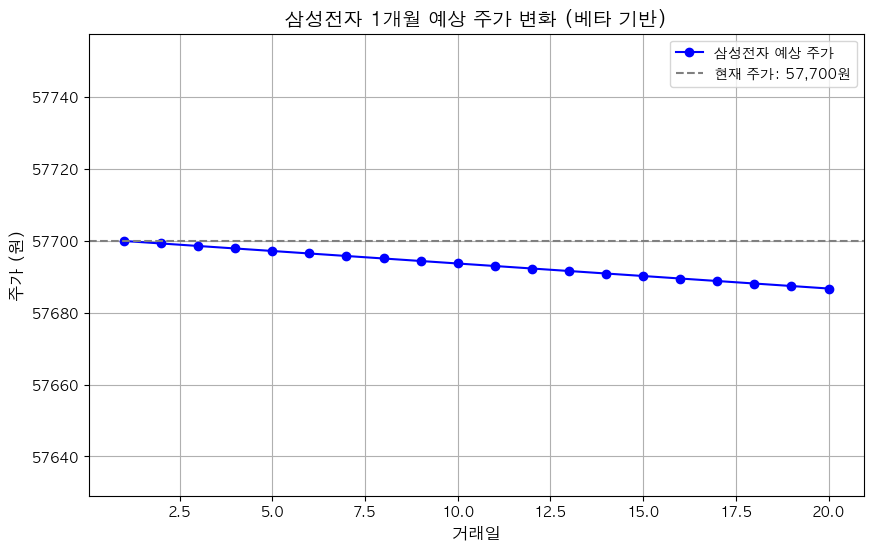

In [89]:
plot_dynamic_stock_price_projection_emphasized(
    stock_name='삼성전자',
    data=final_result,
    risk_free_rate=rf,  # 무위험 수익률
    market_return=Market_Return    # 시장 수익률
)